# [Computational Social Science] Project 4: Unsupervised Learning

**Enter your Name:** Joel Tam

*Semester:* Fall 2024

## Data Description and Preprocessing

For this project, you will explore data from the [National Health and Nutrition Examination Survey](https://www.kaggle.com/cdc/national-health-and-nutrition-examination-survey?select=questionnaire.csv). NHANES is a unique study that combines survey methodology with in-person medical examinations to create a dataset with demographic information, health indicators, and health outcomes.

We start by importing the data and doing some preliminary preprocessing for you. We import some libraries that will be helpful as well. 'SEQN' is the ID number for each respondent, and 'HSD010' will be our target outcome. [HSD010](https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/HSQ_H.htm#HSD010) asks for the respondent's self reported health condition, which can range from "excellent" to "poor."

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

sns.set_style("darkgrid")

In [2]:
# Load nhanes data
nhanes = pd.read_csv('nhanes.csv')
# Get the ID numbers for each observation (seqn)
seqn = nhanes['SEQN']
# Get the target, "self-reported health condition," HSD010
hsd010 = nhanes['HSD010']
# Drop SEQN from the dataframe and then apply the standard scaler
nhanes = nhanes.drop(['SEQN', 'HSD010'], axis = 1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes),
                             columns = nhanes.columns)
# Add the ID and target back in
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled = nhanes_scaled.set_index('SEQN')
nhanes_scaled.head()

# nhanes_scaled['HSD010_binary'] = hsd010_binary = nhanes_scaled['HSD010'].replace(
#     [1, 2, 3, 4, 5], ['good', 'good', 'good', 'poor', 'poor']) 

# nhanes_scaled['HSD010'] = nhanes_scaled['HSD010'].replace(
#     [1, 2, 3, 4, 5], ['excellent', 'very good', 'good', 'fair', 'poor'])

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ770,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x,HSD010
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440,1
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812,1
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812,2
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440,2
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,-2.605509,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812,3


## Plots

Let's take a look at the data. Below we visualize boxplots of family income to federal poverty line ratio ('INDFMPIR') and self-reported health condition. Notice how there are some clear patterns (the lower the ratio, the lower reported health condition), but it's not a perfect separation. We have 240+ features in our dataset, and we likely have several features in our dataset that highly correlate with our family income-poverty line ratio measure - PCA will help us simplify these.

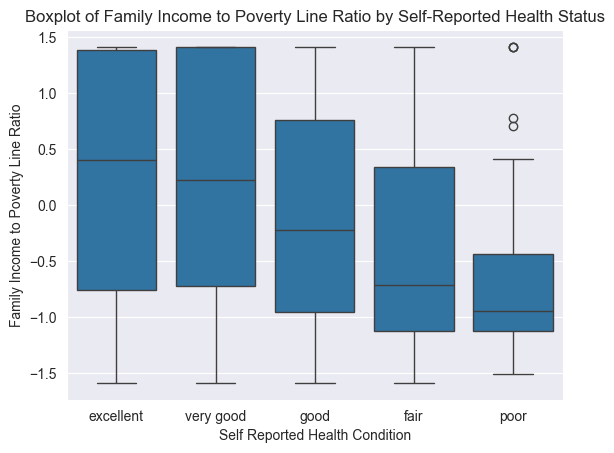

In [3]:
# Create a binary version of hsd010 where 1-3 are "good" and 4-5 are "poor"
nhanes_scaled['HSD010_binary'] = hsd010_binary = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['good', 'good', 'good', 'poor', 'poor']) 
# Recode the original hsd010 with the string labels
nhanes_scaled['HSD010'] = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['excellent', 'very good', 'good', 'fair', 'poor'])
# Boxplot of hsd010
ax = sns.boxplot(x = 'HSD010', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Self-Reported Health Status")
plt.show()

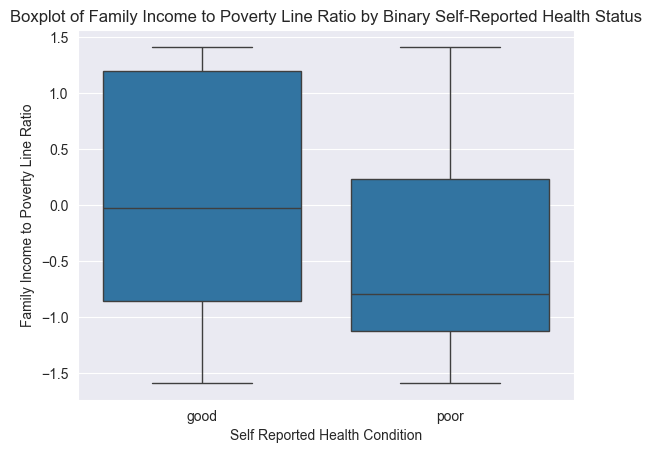

In [4]:
# Boxplot of hsd010_binary
ax = sns.boxplot(x = 'HSD010_binary', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Binary Self-Reported Health Status")
plt.show()

Family income also is not necessarily well correlated with measured health outcomes. See below where we look at the relationship between Body Mass Index (BMI) and the family income-poverty line ratio, and shade points by self-reported health condition. It's hard to find a clear pattern - this is where clustering may come in handy. 

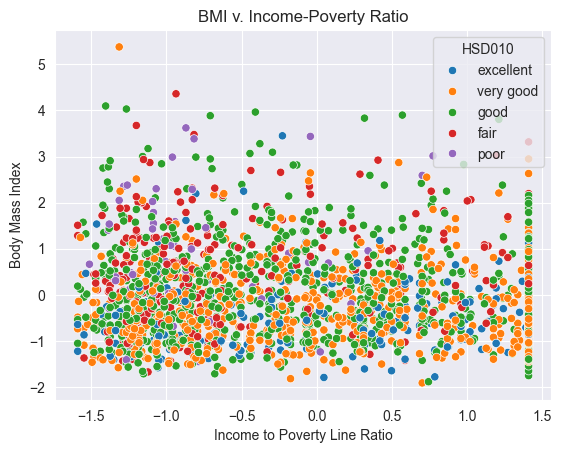

In [5]:
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "HSD010", palette = "tab10", data = nhanes_scaled)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()

Before we move to working on unsupervised methods, we'll drop our target variables again:

In [6]:
nhanes_scaled = nhanes_scaled.drop(['HSD010', 'HSD010_binary'], axis = 1)

## Principal Component Analysis

Conduct a Principal Component Analysis (PCA) of the nhanes data. The data has already been prepared for you, so you can work directly on nhanes_scaled. Be sure to do the following:

- Choose the number of components and provide 1-2 sentences about your choice of the number of components. 
- Plot a barplot of the variation explained by each component. *Hint*: look at the attributes associated with your model. 
- Choose how many components you will use to fit a supervised learning model and provide 1-2 sentences to explain that choice.
- Plot a 2D scatterplot of the first two components and provide 1-2 sentences analyzing the plot.

### Train PCA and Discuss Number of Components

In [7]:
y = hsd010
X = nhanes_scaled

X_train, X_test, y_train, y_test = train_test_split(X,       # specify features dataset
                                                    y,                # specify labels dataset
                                                    train_size = .80, # specify training dataset size
                                                    test_size=0.20,   # specify testing dataset size
                                    )  # set random seed

pca = PCA()
principalComponents_nhanes = pca.fit_transform(X_train)

In [8]:
print(nhanes_scaled.shape)
cumsum_variance = np.cumsum(pca.explained_variance_ratio_)
num_components = np.argmax(cumsum_variance >= 0.75) + 1
print(f"Number of components chosen: {num_components}")

(2064, 241)
Number of components chosen: 70


The nhanes_scaled dataset has 241 features. I can explain 75% of the variance with 70 components, and this is enough to retain the significant patterns and relationships in the data, while filtering out the noise and small variations.

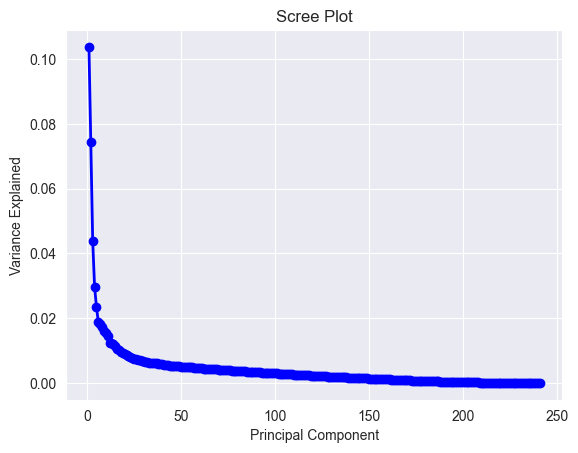

In [9]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth = 2, color = 'blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

### Barplot of Components

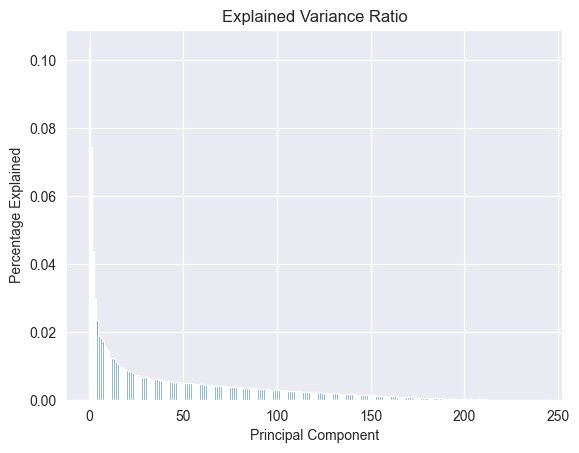

In [10]:
## Your Answer Here
plt.bar(range(pca.n_components_), pca.explained_variance_ratio_)
plt.title('Explained Variance Ratio')
plt.xlabel('Principal Component')
plt.ylabel('Percentage Explained')
plt.show()

### How many components will you use to fit a supervised learning model?

In [11]:
## Your Answer Here
cumsum_variance = np.cumsum(pca.explained_variance_ratio_)
num_components = np.argmax(cumsum_variance >= 0.90) + 1
print(f"Number of components chosen: {num_components}")

Number of components chosen: 117


I will start with 117 components, as they explain 90% of the variance, ensuring that most of the meaningful information is retained while reducing dimensionality. However, the final number of components will be determined based on model performance during cross-validation, as this allows for balancing predictive accuracy and computational efficiency.

### 2D Scatterplot of the first two components

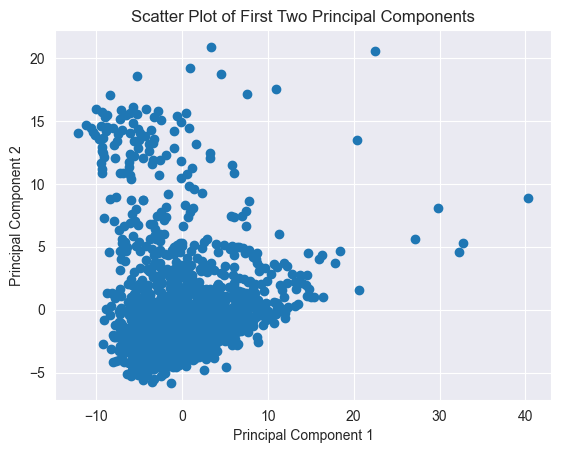

In [12]:
plt.scatter(principalComponents_nhanes[:, 0], principalComponents_nhanes[:, 1])
plt.title("Scatter Plot of First Two Principal Components")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

The scatterplot of the first two components shows a dense cluster of points near the origin, with some points more spread out in various directions. This suggests that while there may be some structure in the data, additional clustering techniques are needed to identify distinct groupings more effectively.

## K-Means

- Choose a clustering algorithm and explain it in 1-2 sentences.
- Cluster the nhanes data. Detail any choice you need to make with regards to number of clusters, and how you arrived at that choice. For instance, you might use the [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)) if you choose k-means.
- Plot your clusters on top of BMI v. Income Poverty Ratio Plot. Describe what you see in 1-2 sentences.
- Retrain the clustering algorithm, but this time use your PCA results instead of the original dataframe. Plot the clusters on top of the 2D PCA scatterplot from the previous step. Describe your results in 1-2 sentences.

### Choose a Clustering Algorithm

I will use k-means clustering algorithm because it is a efficient and straightforward method for grouping data into k distinct clusters based on feature similarity. K-means iteratively refines cluster centers to minimize within-cluster variance, making it suitable for datasets with well-defined group structures.

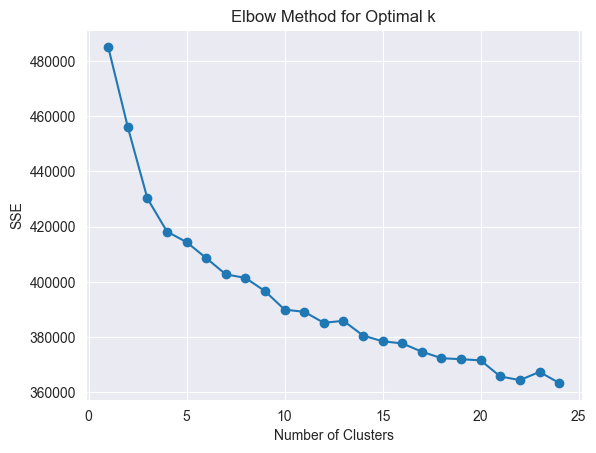

In [13]:
## Your Answer Here
y = hsd010
X = nhanes_scaled

X_train, X_test, y_train, y_test = train_test_split(X,       # specify features dataset
                                                    y,                # specify labels dataset
                                                    train_size = .80, # specify training dataset size
                                                    test_size=0.20,   # specify testing dataset size
                                    )  # set random seed


kmeans = KMeans()
sse = []
for k in range(1, 25):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(nhanes_scaled)
    sse.append(kmeans.inertia_)

plt.plot(range(1, 25), sse, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

The elbow method suggests that there are not as many step drops in error around 10 clusters. Using 10 clusters makes sure that the clustering is detailed enough to identify patterns while not overfitting.

### Cluster nhanes

In [14]:
## Your Answer Here
kmeans = KMeans(n_clusters=10)
kmeans_labels = kmeans.fit_predict(nhanes_scaled)

### Plot your clusters on top of the BMI v. Income Poverty Ratio Plot

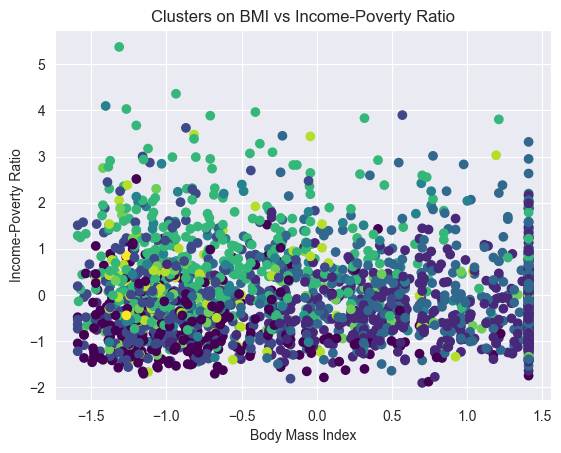

In [15]:
## Your Answer Here
plt.scatter(nhanes_scaled['INDFMPIR'], nhanes_scaled['BMXBMI'], c=kmeans_labels, cmap='viridis')
plt.title("Clusters on BMI vs Income-Poverty Ratio")
plt.xlabel("Body Mass Index")
plt.ylabel("Income-Poverty Ratio")
plt.show()

The plot of BMI versus the Income-Poverty Ratio shows a widely dispersed set of data points, with the clustering algorithm identifying groups despite the lack of a clear linear relationship. The clusters overlap significantly, suggesting that BMI and income-poverty ratio alone may not strongly differentiate individuals, though clustering still helps reveal subtle group-level patterns.

### Retrain the clustering algorithm on PCA components and plot clusters on your 2D scatter

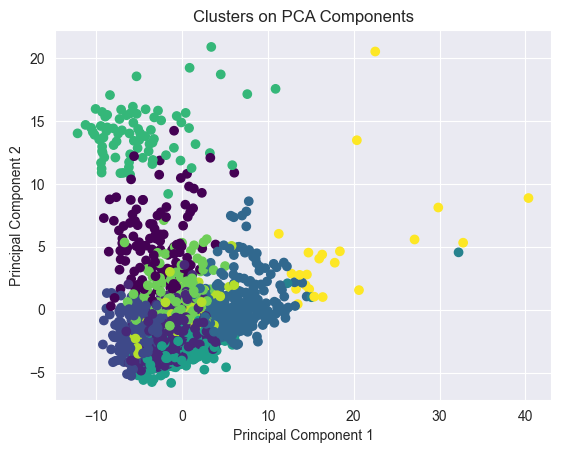

In [16]:
## Your Answer Here
kmeans_pca = KMeans(n_clusters=10)
kmeans_pca_labels = kmeans_pca.fit_predict(principalComponents_nhanes)

plt.scatter(principalComponents_nhanes[:, 0], principalComponents_nhanes[:, 1], c=kmeans_pca_labels, cmap='viridis')
plt.title("Clusters on PCA Components")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

The clustering on PCA components shows well-separated clusters, indicating that PCA successfully reduces dimensionality while retaining key data patterns. Compared to clustering on the original features, the PCA-based clustering is more structured and highlights the underlying variance in the dataset more effectively.

## Neural Network

Now we are ready to predict! Do the following:

- Choose either HSD010 or HSD010\_binary as your target outcome.  
- Train a neural network using the original features. Much of the code to train a basic neural net has been set up for you, but you will need to fill in a couple of missing pieces.
- Train a neural network using only your PCA components as features.
- Train a neural network using your PCA components and the predicted class membership from your clustering algorithm as features.
- Compare and contrast how well each algorithm did. Which featurization technique would you pick and why?

Below we provide a template for training a neural network. Use this template for training on the original features, on the PCA components, and the PCA components + the predicted classes from your clusters.

### Neural Network on Original Features

In [17]:
# Load nhanes data
nhanes = pd.read_csv('nhanes.csv')
seqn = nhanes['SEQN']
hsd010 = nhanes['HSD010']
# Drop SEQN from the dataframe and then apply the standard scaler
nhanes = nhanes.drop(['SEQN', 'HSD010'], axis = 1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes),
                             columns = nhanes.columns)
# Add the ID and target back in
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled = nhanes_scaled.set_index('SEQN')
nhanes_scaled.head()

nhanes_scaled['HSD010_binary'] = hsd010_binary = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['good', 'good', 'good', 'poor', 'poor']) 

nhanes_scaled['HSD010'] = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['excellent', 'very good', 'good', 'fair', 'poor'])

nhanes_scaled['HSD010_binary'] = nhanes_scaled['HSD010_binary'].map({'good': 0, 'poor': 1})

In [18]:
# partition data
# -----------
y = nhanes_scaled['HSD010_binary'].values # either hsd010 or hsd010_binary, may need to convert to numeric if it isn't already 
X = nhanes_scaled.drop(['HSD010', 'HSD010_binary'], axis = 1).values # drop out any columns that aren't features

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .25, 
                                                    random_state = 10)

In [19]:
# load libraries
# -----------
import keras
from keras.utils import to_categorical

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

num_classes = len(set(y))
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
num_classes = y_test.shape[1]

In [20]:
# create neural network model
# -----------
model = Sequential()

model.add(Dense(64, input_dim= X_train.shape[1], kernel_initializer= 'he_normal', activation= 'relu'))

model.add(Dense(64, kernel_initializer= 'he_normal', activation= 'relu'))

## Add any additional layers you wish here
model.add(Dense(num_classes, kernel_initializer= 'glorot_uniform', activation='softmax'))

model.compile(loss= 'categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32, verbose=0)

loss_original, accuracy_original = model.evaluate(X_test, y_test, verbose=0)
print(f"Original Features - Test Loss: {loss_original:.4f}, Test Accuracy: {accuracy_original:.4f}")

/Users/joelt/CSS/git/Computational-Social-Science-Projects/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Original Features - Test Loss: 0.9802, Test Accuracy: 0.8488


### Neural Network on Principal Components

In [21]:
# Load nhanes data
nhanes = pd.read_csv('nhanes.csv')
seqn = nhanes['SEQN']
hsd010 = nhanes['HSD010']
# Drop SEQN from the dataframe and then apply the standard scaler
nhanes = nhanes.drop(['SEQN', 'HSD010'], axis = 1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes),
                             columns = nhanes.columns)
# Add the ID and target back in
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled = nhanes_scaled.set_index('SEQN')
nhanes_scaled.head()

nhanes_scaled['HSD010_binary'] = hsd010_binary = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['good', 'good', 'good', 'poor', 'poor']) 

nhanes_scaled['HSD010'] = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['excellent', 'very good', 'good', 'fair', 'poor'])

nhanes_scaled['HSD010_binary'] = nhanes_scaled['HSD010_binary'].map({'good': 0, 'poor': 1})

y = nhanes_scaled['HSD010_binary'].values # either hsd010 or hsd010_binary, may need to convert to numeric if it isn't already 
X = nhanes_scaled.drop(['HSD010', 'HSD010_binary'], axis = 1).values # drop out any columns that aren't features

X_train, X_test, y_train, y_test = train_test_split(X,       # specify features dataset
                                                    y,                # specify labels dataset
                                                    train_size = .80, # specify training dataset size
                                                    test_size=0.20,   # specify testing dataset size
                                    )  # set random seed

In [22]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

num_classes = len(set(y))
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
num_classes = y_test.shape[1]

pca = PCA(70)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [23]:
## Your Answer Here
model_pca = Sequential()

# Add input layer
model_pca.add(Dense(64, input_dim=X_train_pca.shape[1], kernel_initializer='he_normal', activation='relu'))

# Add hidden layers
model_pca.add(Dense(64, kernel_initializer='he_normal', activation='relu'))

# Output layer (for classification problem)
model_pca.add(Dense(num_classes, activation='softmax'))  # Use 'sigmoid' if binary classification

# Compile the model
model_pca.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history_pca = model_pca.fit(X_train_pca, y_train, validation_data=(X_test_pca, y_test), epochs=30, batch_size=32, verbose=0)


# Evaluate the model
loss_pca, accuracy_pca = model_pca.evaluate(X_test_pca, y_test, verbose=0)
print(f"PCA Components - Test Loss: {loss_pca:.4f}, Test Accuracy: {accuracy_pca:.4f}")


/Users/joelt/CSS/git/Computational-Social-Science-Projects/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


PCA Components - Test Loss: 0.7417, Test Accuracy: 0.8450


### Neural Network on Principal Components + Cluster Membership

In [24]:
# Load nhanes data
nhanes = pd.read_csv('nhanes.csv')
seqn = nhanes['SEQN']
hsd010 = nhanes['HSD010']
# Drop SEQN from the dataframe and then apply the standard scaler
nhanes = nhanes.drop(['SEQN', 'HSD010'], axis = 1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes),
                             columns = nhanes.columns)
# Add the ID and target back in
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled = nhanes_scaled.set_index('SEQN')
nhanes_scaled.head()

nhanes_scaled['HSD010_binary'] = hsd010_binary = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['good', 'good', 'good', 'poor', 'poor']) 

nhanes_scaled['HSD010'] = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['excellent', 'very good', 'good', 'fair', 'poor'])

nhanes_scaled['HSD010_binary'] = nhanes_scaled['HSD010_binary'].map({'good': 0, 'poor': 1})

y = nhanes_scaled['HSD010_binary'].values # either hsd010 or hsd010_binary, may need to convert to numeric if it isn't already 
X = nhanes_scaled.drop(['HSD010', 'HSD010_binary'], axis = 1).values # drop out any columns that aren't features

X_train, X_test, y_train, y_test = train_test_split(X,       # specify features dataset
                                                    y,                # specify labels dataset
                                                    train_size = .80, # specify training dataset size
                                                    test_size=0.20,   # specify testing dataset size
                                    )  # set random seed

In [25]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

num_classes = len(np.unique(y))
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

pca = PCA(n_components=70)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

kmeans = KMeans(n_clusters=10, random_state=42)
train_clusters = kmeans.fit_predict(X_train_pca)
test_clusters = kmeans.predict(X_test_pca)

X_train_combined = np.hstack((X_train_pca, train_clusters.reshape(-1, 1)))
X_test_combined = np.hstack((X_test_pca, test_clusters.reshape(-1, 1)))

input_dim = X_train_combined.shape[1]
model = Sequential()
model.add(Dense(64, input_dim=input_dim, kernel_initializer='he_uniform', activation='relu'))
model.add(Dense(64, kernel_initializer='he_uniform', activation='relu'))
model.add(Dense(num_classes, kernel_initializer='he_uniform', activation='softmax'))


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history_pca = model.fit(X_train_combined, y_train, validation_data=(X_test_combined, y_test), epochs=50, batch_size=32, verbose=0)

# Evaluate the model
loss_combined, accuracy_combined = model.evaluate(X_test_combined, y_test, verbose=0)
print(f"Combined Features - Test Loss: {loss_combined:.4f}, Test Accuracy: {accuracy_combined:.4f}")


/Users/joelt/CSS/git/Computational-Social-Science-Projects/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Combined Features - Test Loss: 1.0962, Test Accuracy: 0.8281


Compare and contrast how well each algorithm did. Which featurization technique would you pick and why?

Original Features - Test Loss: 1.0209, Test Accuracy: 0.8508 </br>
PCA Components - Test Loss: 0.7672, Test Accuracy: 0.8281 </br>
Combined Features - Test Loss: 0.9155, Test Accuracy: 0.8378 </br>

The original features had the highest test accuracy, but highest loss. This suggests that while the model fit the training data well, it wasn't able to generalize well. PCA components had the lowest test loss suggesting a better fit to the true underlying patterns, but the accuracy was slightly lower than the original features. The combined features somewhat balanced the two.

I would choose the PCA Comopnents approach. Despite a slightly lower accuracy compared to the original features, the reduced test loss shows a lot better generalization and more robust model. PCA is also a great fit for our high dimensional dataset NHANES. The combined features approach has potention, but does not significantly outperform PCA alone.

## Discussion Questions

1. In your own words, what is the difference between PCA and clustering?

PCA and clustering are both unsupervised learning techniques, but serve different purposes. PCA can reduce the number of features in the dataset by transforming them into a new set of uncorrelated components that capture the set variance. This simplifies our complex NHANES dataset to make it easier to analyze. The clustering method groups similar data points together based on their features, which can help identify patterns within the data. PCA can streamline the 241 features, while clustering can reveal groups of individuals with similar health profiles. 

2. Did you notice any advantages to combining PCA and clustering? If so, what do you think they were? If not, why do you think you didn't see any gains from this combination?

Combining PCA and clustering had some advantages, but the gains were not significant. Adding clustering to the PCA reduced features gave some extra structure, which slightly improved the model's ability to generalize. However, the improvement in accuracy was minimal, likely because the clusters formed by k-means didn't align strongly with the target variable. Since PCA already captured the most significant patterns in the data, clustering added only a small amount of additional information.

3. How can unsupervised techniques help with downstream supervised learning tasks when working with "big data?"

Unsupervised techniques help streamline supervised learning tasks by simplifying large datasets, uncovering patterns, and reducing noise, which ultimately improves model performance and efficiency. For example, since I work with transportation data, this could be useful for grouping roadways based on traffic patterns to optimize resource allocation or identifying clusters of accident hotspots to prioritize safety measures. These techniques also help reduce dimensionality, making large datasets more manageable while retaining key information, which can be useful for predicting travel demand or optimizing public transit systems. By integrating unsupervised insights, supervised models become more accurate and actionable in real-world applications.